## Lab 4: Gridded data in Python

**Objectives:**
   * We will learn how to read, inspect, and write gridded data using <code>rasterio</code> and <code>xarray</code>.
   * Learn how to index, slice and manipulate our gridded data.
   * Export our data as <code>GeoTIFF</code> or <code>NetCDF</code> format.

In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

## Finding day of year
from datetime import datetime, date

## Finding address from coordinates
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Define filepath
filepath = './data/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))

# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [3]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')
xds_daily = xds.resample(time='1D').mean()

*******
## Question 1 (10 points):

Find the following numbers in the climate reanalysis dataset:

* a) the air temperature (in F) **and** cloud cover (in %) in Florence, OR (in 2020) on **January 31, 2020**?
* b) the air temperature (in F) **and** cloud cover (in %) in **Eugene, OR** (in 2020) on **February 15, 2020**?

You can use the following table to convert from a **date** to a **day-of-year**: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [26]:
# Specific date
day_of_year_1 = date(2020, 1, 31).timetuple().tm_yday
print("Day of year: ", day_of_year_1)

# find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

mean_temp = (florence_weather['t2m'][day_of_year_1-1].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))
mean_cloud = florence_weather['tcc'][day_of_year_1-1].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100), "\n")

# find the index of the grid point nearest a specific lat/lon.   
eugene_weather = xds_daily.sel(latitude=44.0521, longitude=-123.0868, method='nearest')

day_of_year_2 = date(2020, 2, 15).timetuple().tm_yday
print("Day of year: ", day_of_year_2)

mean_temp = (eugene_weather['t2m'][day_of_year_2-1].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Eugene on February 15, 2020 = %.2f F' % (mean_temp))
mean_cloud = eugene_weather['tcc'][day_of_year_2-1].mean()
print('Mean cloud cover in Eugene on February 15, 2020 = %.2f %%' % (mean_cloud * 100))

Day of year:  31
Mean air temp. in Florence in 2020 = 53.82 F
Mean cloud cover in Florence in 2020 = 99.98 % 

Day of year:  46
Mean air temp. in Eugene on February 15, 2020 = 42.00 F
Mean cloud cover in Eugene on February 15, 2020 = 99.99 %


**********

## Question 2 (20 points): 

Find the following grid cells in the climate reanalysis dataset and provide the lat/lons **and** a rough location of where they are located. 

* a) Highest average air temperature (i.e. hottest place)
* b) Lowest average air temperature (i.e. coldest place)
* c) Highest average cloudiness (i.e. cloudiest place)
* d) Lowest average cloudiest (i.e. least cloudy place)
* e) Place with highest range in air temperature
* f) Place with the absolute coldest temperature on a single day 

You can copy and paste the lat/lons into Google Maps to find a rough location of where these places are. 

In [5]:
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

#use a geocoder to reverse search for address
geocoder = Nominatim(user_agent="jsheppar@uoregon.edu")
location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest average temperature is: %s" %location)

lat = 28.990000, lon = -111.250000
The location with the highest average temperature is: Granja Guadalupe, Hermosillo, Sonora, México


In [21]:
min_value = np.mean(xds_daily['t2m'], axis=0).argmin()
index = np.unravel_index(min_value, np.mean(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the lowest average temperature is: %s" %location)

lat = 43.990002, lon = -109.750000
The location with the lowest average temperature is: Park County, Wyoming, United States


In [22]:
max_value = np.mean(xds_daily['tcc'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['tcc'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest average total cloud cover is: %s" %location)

lat = 49.240002, lon = -125.000000
The location with the highest average total cloud cover is: Stirling Arm Road, Area D (Sproat Lake), British Columbia, Canada


In [23]:
min_value = np.mean(xds_daily['tcc'], axis=0).argmin()
index = np.unravel_index(min_value, np.mean(xds_daily['tcc'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the lowest average total cloud cover is: %s. The geocoder is a little vague, "
      "but \n google maps shows that this is located in the Gulf of California" %location)

lat = 31.490000, lon = -114.750000
The location with the lowest average total cloud cover is: México. The geocoder is a little vague, but 
 google maps shows that this is located in the Gulf of California


In [24]:
max_range = (np.max(xds_daily['t2m'], axis=0) - np.min(xds_daily['t2m'], axis=0)).argmax()
index = np.unravel_index(max_range, np.max(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest range in temperature is: %s" %location)

lat = 48.990002, lon = -72.500000
The location with the highest range in temperature is: Girardville, Maria-Chapdelaine, Saguenay–Lac-Saint-Jean, Québec, G0W 1R0, Canada


In [25]:
min_abs = np.min(xds_daily['t2m'], axis=0).argmin()
index = np.unravel_index(min_abs, np.min(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]
print("lat = %f, lon = %f" %(lat, lon))

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest range in temperature is: %s" %location)

lat = 48.740002, lon = -111.250000
The location with the highest range in temperature is: Oilmont Road, Liberty County, Montana, United States


***********
## Question 3 (20 points):  


Display the Landsat image of Florence, OR as:

* a)  an **NDVI** image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))
* b)  a **color infrared composite** (i.e. bands 5, 4, 3)

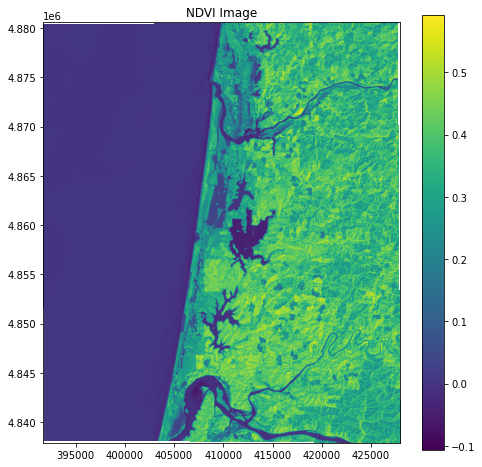

In [11]:
# Compute NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI Image")
fig.colorbar(im, orientation='vertical')
plt.show()

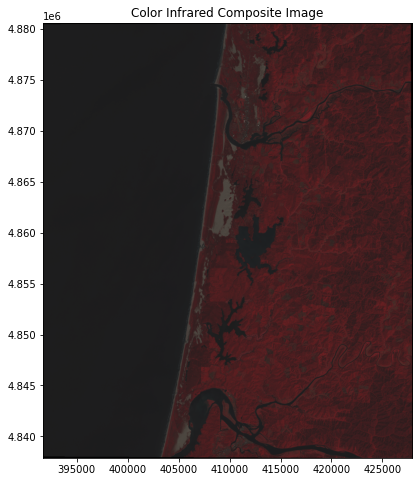

In [12]:
# Produce a new array by stacking the RGB bands
inf_comp = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(inf_comp, extent=full_extent)
ax.set_title("Color Infrared Composite Image")
plt.show()

*********

## Question 4 (for grad students/extra credit)

* a) Produce an NDWI histogram for the Landsat image of Florence 
* b) Choose a threshold and produce a binary water mask
* c) Compute the area of water in the image (including ocean)

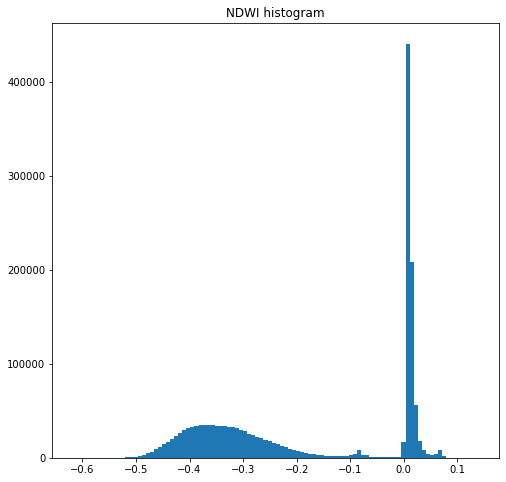

In [29]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

# Plot NDWI histogram
fig, ax = plt.subplots(figsize=(8,8))
im = ax.hist(ndwi[~np.isnan(ndwi)], bins=100)
ax.set_title("NDWI histogram")
plt.show()

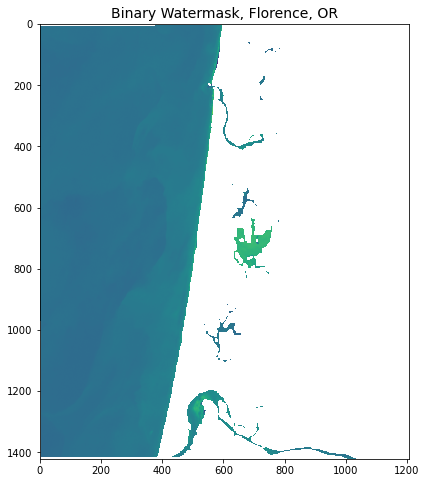

In [14]:
# threshold
thresh = -0.07
ndwi_masked = np.ma.masked_array(ndwi, mask=(ndwi < thresh))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi_masked)

ax.set_title("Binary Watermask, Florence, OR", fontsize=14)
plt.show()

In [15]:
gt = src.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print("Each pixel is %f x %f meters." %(pixelSizeX, pixelSizeY))

water_area = ndwi_masked.count() * (pixelSizeX*pixelSizeY)
water_area /= 1000000
print("There is approximately %f square kilometers of water in the image." %water_area)

Each pixel is 30.000000 x 30.000000 meters.
There is approximately 709.748100 square kilometers of water in the image.
